In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import timm
import os
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from skimage import io
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import cv2
import random

## Cuda


In [2]:
#Controllo che torch sia installato con CUDA abilitato
def check_cuda():
    print(torch.version.cuda)
    cuda_is_ok = torch.cuda.is_available()
    print(f"CUDA Enabled: {cuda_is_ok}")

In [3]:
print(torch.version.cuda)

11.7


## Model parameters


In [4]:
model_weights = True

In [5]:
#Directory per i file di train
DATA_DIR = ''

#Grandezza del Batch (iperparametro)
BATCH_SIZE = 32

#Learning Rate (Iperparametro)
LR = 0.001

#Numero di epoche (Iperparametro)
EPOCHS = 80

DEVICE = 'cuda'

## Dataloader and dataset creation

In [6]:
# Carica il file csv
df_real = pd.read_csv("real_image_dataset_coco2.csv")

df_fake = pd.read_csv("fake_image_dataset_biggan_latent_taming.csv")

train_df_real, valid_df_real = train_test_split(df_real, test_size = 0.20, random_state = 42)
train_df_fake, valid_df_fake = train_test_split(df_fake, test_size = 0.20, random_state = 42)

#test_df_real = train_df_real.sample(500)
#test_df_fake = train_df_fake.sample(500)

#train_df_real = train_df_real.drop(test_df_real.index)
#train_df_fake = train_df_fake.drop(test_df_fake.index)

train_df = pd.concat([train_df_real, train_df_fake])
valid_df = pd.concat([valid_df_real, valid_df_fake])

#test_df = pd.concat([test_df_fake, test_df_real])

# shuffle
train_df= train_df.sample(frac= 1)
valid_df= valid_df.sample(frac= 1)

# Unisci tutti i dataframe in un unico dataframe finale per il train set
final_df = pd.concat([train_df, valid_df])

# Salva il dataframe finale di trian in un file CSV
#final_df.to_csv("spectrum_train_dataset_2train.csv", index=False)
df = pd.read_csv("spectrum_train_dataset_2train.csv")

# Crea una lista combinata con 500 immagini false seguite da 500 immagini reali
#combined_images = test_df["Anchor"]

# Crea il dataframe del test set con una sola colonna
#test_df = pd.DataFrame(combined_images)

# Salva il dataframe del test set in un file CSV
#test_df.to_csv("test_set_biggan_2train.csv", index=False, header=False)

print('Size of train set:', len(train_df))
print('Size of valid set:', len(valid_df))
#print('Size of test set:', len(test_df))

Size of train set: 24000
Size of valid set: 6000


In [7]:
# Carico le immagini del file CSV che ho fornito, per settarle in modo corretto e darle in input alla rete neurale
class APN_Dataset(Dataset):

  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    A_img = io.imread(DATA_DIR + row.Anchor, as_gray= True)
    P_img = io.imread(DATA_DIR + row.Positive, as_gray= True)
    N_img = io.imread(DATA_DIR + row.Negative, as_gray= True)

    
    # Aggiungi dimensione per il batch
    A_img = np.expand_dims(A_img, 0)
    P_img = np.expand_dims(P_img, 0)
    N_img = np.expand_dims(N_img, 0)

    A_img = torch.from_numpy(A_img)/ 255.0
    P_img = torch.from_numpy(P_img)/ 255.0
    N_img = torch.from_numpy(N_img)/ 255.0
      
    #A_img = torch.from_numpy(A_img.astype(np.int32)) / 65536.0
    #P_img = torch.from_numpy(P_img.astype(np.int32)) / 65536.0
    #N_img = torch.from_numpy(N_img.astype(np.int32)) / 65536.0

    return A_img, P_img, N_img

In [8]:
data = APN_Dataset(train_df)
item1, item2, item3 = data.__getitem__(0)
print(item1.shape)

torch.Size([1, 200, 200])


Qui di seguito mi stampo il numero che compone l'insieme di dati di train, test e validation

In [9]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)
#testset = APN_Dataset(test_df)

print(f"Size of trainset: {len(trainset)}")
print(f"Size of validset: {len(validset)}")
#print(f"Size of validset: {len(testset)}")

Size of trainset: 24000
Size of validset: 6000


Carichiamo i dati di train e validation nella batch

In [10]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)
#testloader = DataLoader(testset, batch_size = 1)

In [11]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")
#print(f"No. of batches in testloader : {len(testloader)}")

No. of batches in trainloader : 750
No. of batches in validloader : 188


Questa funzione definisce un modello di rete neurale chiamato APN_Model, che carica un'architettura di rete preaddestrata e sostituisce il classificatore finale con un nuovo classificatore personalizzato.

## Model definition

In [12]:
#Carico il modello di rete neurale
class APN_Model(nn.Module):

    #Viene definita la size del vettore di embedding
  def __init__(self, emb_size = 512):
    super(APN_Model, self).__init__()

    #QUI CAIRCATE IL MODELLO, IN QUESTO CASO EFFICIENTNET VERSIONE B0 (LA PIù LEGGERA DELLA FAMIGLIA)
    self.efficientnet = timm.create_model('tf_efficientnetv2_b0', pretrained = False)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features = emb_size)

  def forward(self, images):
    embeddings = self.efficientnet(images)
    return embeddings

In [13]:
#QUI FATE UNA PICCOLA MODIFICA ALLA RETE PER FARLE AVERE IN INPUT IMMAGINI IN SCALA DI GRIGIO DELLO SPETTRO DI FOURIER
model = APN_Model()
model.efficientnet.conv_stem = nn.Conv2d(1, 32, 3, 2, 1, bias=False);

if model_weights == True :
    model.load_state_dict(torch.load('trained_model_on_30000.pt'))

model.to(DEVICE);

## Evaluation functions

In [14]:
#FUNZIONE DI TRAINING
def train_fn(model, dataloader, optimizer, criterion):
  model.train() #ON Dropout
  total_loss = 0.0

  for A, P, N in tqdm(dataloader):
    A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    loss = criterion(A_embs, P_embs, N_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [15]:
#FUNZIONE DI EVALUATION
def eval_fn(model, dataloader, criterion):
  model.eval() #OFF Dropout
  total_loss = 0.0

  with torch.no_grad():
    for A, P, N in tqdm(dataloader):
      A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)

      loss = criterion(A_embs, P_embs, N_embs)

      total_loss += loss.item()

    return total_loss / len(dataloader)

In [16]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')
        self.model = None

    def early_stop(self, validation_loss, model_updated):
        print(validation_loss)
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            print("New min - model updated")
            self.model = model_updated
            torch.save(self.model, 'trained_model_on_30000.pt')
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            print(f"Counter updated {self.min_validation_loss + self.min_delta}")
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

    def get_model(self):
        return self.model

## Training parameters

In [17]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [18]:
early_stopper = EarlyStopper(patience=5, min_delta=0.08)

## Training

In [19]:
#Training
if model_weights == False :
    best_valid_loss = np.Inf
    training_loss = []
    validation_loss = []
    for i in range(EPOCHS):
      train_loss = train_fn(model, trainloader, optimizer, criterion)
      valid_loss = eval_fn(model, validloader, criterion)
      training_loss.append(train_loss)
      validation_loss.append(valid_loss)
      if early_stopper.early_stop(valid_loss, model.state_dict()):             
          break
          
      print(f"EPOCHS : {i+1} train_loss : {train_loss} valid_loss : {valid_loss}")
    torch.save(early_stopper.get_model(), 'trained_model_on_30000.pt')


In [20]:
#Salvataggio plottato dei dati
if(model_weights == False):    
    fig, axes = plt.subplots(2, 1, sharex= True, figsize=(10, 6))
    axes[0].plot(training_loss)
    axes[0].set_title('Training Loss - Triplet margin loss')
    axes[1].plot(validation_loss)
    axes[1].set_title('Validation Loss - Triplet margin loss')
    plt.savefig('training_data_30000(biggan_latent_taming)-80-epochs.png')
    plt.show()

## Databse training embedded

In [21]:
#QUESTA E' LA FUNZIONE PER GENERARE I VETTORI DI ENCODING
# concatenating images name and relative encodings
def get_encoding_csv(model, anc_img_names, dirFolder):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()

  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):
      A = io.imread(dirFolder + i)
      A = np.expand_dims(A, 0)
      A = torch.from_numpy(A.astype(np.int32)) / 255.0
      A = A.to(DEVICE)
      A_enc = model(A.unsqueeze(0))
      encodings.append(A_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([anc_img_names, encodings], axis = 1)

    return df_enc

In [22]:
#QUI CREO IL DATABASE DI FEATURE VECTORS DEL TRAINING SET
df_enc = get_encoding_csv(model, df['Anchor'], DATA_DIR)

100%|████████████████████████████████████████████████████████████████████████████| 29000/29000 [05:41<00:00, 84.96it/s]


In [23]:
#QUI IL DATABASE COME CSV IN MODO TALE DA NON DOVER FARE QUESTA OPERAZIONE OGNI VOLTA
#OVVIAMENTE, SE DEVO FARE UN NUOVO TRAINING DEVO ANCHE RICREARE GLI ENCODINGS
if(model_weights == False):
    df_enc.to_csv('database_embed_(biggan_latent_taming-coco).csv', index = False)
    df_enc.head()
else:
    df_enc = pd.read_csv('database_embed_(biggan_latent_taming-coco).csv')

## Distances, Get image embeddings and searching in databse

In [24]:
def euclidean_dist(img_enc, anc_enc_arr):
    dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc- anc_enc_arr).T))
    #dist = np.dot(img_enc-anc_enc_arr, (img_enc- anc_enc_arr).T)
    #dist = np.sqrt(dist)
    return dist

In [25]:
# return the embedding of the image
def getImageEmbeddings(img, model):

    img = np.expand_dims(img, 0)
    img = torch.from_numpy(img) / 255
    model.eval();

    with torch.no_grad():
        img = img.to(DEVICE)
        img_enc = model(img.unsqueeze(0))
        img_enc = img_enc.detach().cpu().numpy()
        img_enc = np.array(img_enc)

    return img_enc

## Few-shot Learning

In [26]:
(df_enc.describe())

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
count,29000.000000,29000.000000,29000.000000,29000.000000,29000.000000,29000.000000,29000.000000,29000.000000,29000.000000,29000.000000,...,29000.000000,29000.000000,29000.000000,29000.000000,29000.000000,29000.000000,29000.000000,29000.000000,29000.000000,29000.000000
mean,-0.216455,-0.712977,1.114976,0.722931,-1.031491,-0.648398,-1.089123,0.231121,-1.057077,-0.677287,...,-1.376856,1.351983,0.940181,0.407899,0.631123,-2.134334,0.596049,1.406200,-1.537396,-0.314871
std,0.001285,0.009445,0.003208,0.002476,0.006039,0.002247,0.008073,0.001865,0.003734,0.004002,...,0.005824,0.004717,0.003489,0.003556,0.008372,0.006175,0.002395,0.003844,0.007012,0.002194
min,-0.221841,-0.738009,1.101873,0.713073,-1.058341,-0.657568,-1.111069,0.224129,-1.071593,-0.693642,...,-1.406101,1.334850,0.926909,0.397657,0.602113,-2.159127,0.584007,1.389530,-1.574284,-0.321045
25%,-0.217318,-0.720305,1.112847,0.721310,-1.036531,-0.649827,-1.094884,0.229904,-1.059466,-0.680645,...,-1.380902,1.348635,0.937882,0.405249,0.624350,-2.138249,0.594595,1.403917,-1.542023,-0.316815
50%,-0.216537,-0.716266,1.114804,0.722644,-1.030155,-0.648342,-1.090748,0.230930,-1.056882,-0.676477,...,-1.377438,1.351389,0.939661,0.406692,0.633446,-2.134074,0.596252,1.406089,-1.538113,-0.314994
75%,-0.215632,-0.704340,1.116990,0.724579,-1.027401,-0.646978,-1.082842,0.232133,-1.054591,-0.674365,...,-1.373183,1.354928,0.942749,0.411458,0.637273,-2.130281,0.597638,1.408526,-1.532991,-0.312833
max,-0.209728,-0.683712,1.132569,0.735858,-1.012226,-0.638531,-1.061427,0.239395,-1.041203,-0.665591,...,-1.352973,1.374712,0.956903,0.418860,0.651853,-2.107503,0.603344,1.427005,-1.507892,-0.309354


In [50]:
# Funzione per ottenere i percorsi delle immagini
def get_image_paths(folder):
    image_paths = []
    for root, dirs, files in os.walk(folder):
        for filename in files:
            if filename.endswith(".jpg"):
                image_paths.append(os.path.relpath(os.path.join(root, filename)))
    return image_paths

In [51]:
current_dir = os.getcwd()
fake_image_folder_cyclegan = os.path.join(current_dir, "dataset", "cycle_gan", "st", "monet2photo_spectrum")
fake_image_folder_diffusiongan = os.path.join(current_dir, "dataset", "diffusion_gan", "diff", "afhq-data", "Diffusion-StyleGAN2-ADA-AFHQ_Spectrum")
fake_image_folder_stableDiff = os.path.join(current_dir, "dataset", "stable_diffusion", "stable", "images_spectrum")

fake_image_paths_cyclegan = get_image_paths(fake_image_folder_cyclegan)
fake_image_paths_diffusiongan = get_image_paths(fake_image_folder_diffusiongan)
fake_image_paths_stableDiff = get_image_paths(fake_image_folder_stableDiff)

print("Numero di immagini cyclegan:", len(fake_image_paths_cyclegan))
print("Numero di immagini diffusiongan:", len(fake_image_paths_diffusiongan))
print("Numero di immagini stableDiff:", len(fake_image_paths_stableDiff))

# Selezionare un numero casuale di immagini
num_random_elements = 1500
cyclegan_random = random.sample(fake_image_paths_cyclegan, num_random_elements)
diffusiongan_random = random.sample(fake_image_paths_diffusiongan, num_random_elements)
#stableDiff = random.sample(fake_image_paths_stableDiff, num_random_elements)

stableDiff_selected = fake_image_paths_stableDiff[:num_random_elements]

# Ottenere gli embedding delle immagini selezionate
embeddings_new_cyclegan_diffusiongan_stableDiff_imgs = []
image_paths = []

for i in range(num_random_elements):
    cyclegan_random_img = io.imread(cyclegan_random[i])
    diffusiongan_random_img = io.imread(diffusiongan_random[i])
    #stableDiff_random_img = io.imread(stableDiff_selected[i])
    stableDiff_img = io.imread(stableDiff_selected[i])
    
    cyclegan_random_img_embed = getImageEmbeddings(cyclegan_random_img, model)[0, :]
    diffusiongan_random_img_embed = getImageEmbeddings(diffusiongan_random_img, model)[0, :]
    #stableDiff_random_img_embed = getImageEmbeddings(stableDiff_random_img, model)[0, :]
    stableDiff_img_embed = getImageEmbeddings(stableDiff_img, model)[0, :]
    
    embeddings_new_cyclegan_diffusiongan_stableDiff_imgs.append(cyclegan_random_img_embed)
    embeddings_new_cyclegan_diffusiongan_stableDiff_imgs.append(diffusiongan_random_img_embed)
    #embeddings_new_cyclegan_diffusiongan_stableDiff_imgs.append(stableDiff_random_img_embed)
    embeddings_new_cyclegan_diffusiongan_stableDiff_imgs.append(stableDiff_img_embed)
    
    image_paths.append(cyclegan_random[i])
    image_paths.append(diffusiongan_random[i])
    #image_paths.append(stableDiff_random[i])
    image_paths.append(stableDiff_selected[i])

Numero di immagini cyclegan: 2386
Numero di immagini diffusiongan: 2000
Numero di immagini stableDiff: 19000


In [52]:
# Creare un DataFrame con gli embedding e i percorsi delle immagini
df_cycle_diffusion_stableDiff_new = pd.DataFrame(embeddings_new_cyclegan_diffusiongan_stableDiff_imgs, columns=[f'{i}' for i in range(len(embeddings_new_cyclegan_diffusiongan_stableDiff_imgs[i]))])
df_cycle_diffusion_stableDiff_new['Anchor'] = image_paths

# Verifica del DataFrame creato
print("Nuovo DataFrame con embedding e percorsi delle immagini:")
print(df_cycle_diffusion_stableDiff_new.head())

# Concatenare con il DataFrame esistente
df_enc_plus_cycle_diffusion_stableDiff = pd.concat([df_enc, df_cycle_diffusion_stableDiff_new], ignore_index=True)

# Salviamo il DataFrame risultante in un CSV
df_enc_plus_cycle_diffusion_stableDiff.to_csv('new_database_with(1500-cycle_1500-diffusion_1500-stableDiff).csv', index=False)

saved_df = pd.read_csv('new_database_with(1500-cycle_1500-diffusion_1500-stableDiff).csv')

Nuovo DataFrame con embedding e percorsi delle immagini:
          0         1         2         3         4         5         6  \
0 -0.215798 -0.723515  1.114003  0.719566 -1.023261 -0.649960 -1.098855   
1 -0.215308 -0.718420  1.114775  0.722085 -1.030096 -0.648896 -1.093627   
2 -0.218375 -0.702039  1.115767  0.723837 -1.031165 -0.647296 -1.079754   
3 -0.216335 -0.720570  1.113002  0.720982 -1.027527 -0.648423 -1.094231   
4 -0.216428 -0.725385  1.114957  0.721186 -1.025268 -0.650899 -1.100488   

          7         8         9  ...       503       504       505       506  \
0  0.234710 -1.060269 -0.671736  ...  1.347341  0.935386  0.402837  0.639949   
1  0.232961 -1.058204 -0.675057  ...  1.350751  0.939002  0.406103  0.635763   
2  0.226011 -1.054420 -0.680643  ...  1.357456  0.940013  0.411524  0.624037   
3  0.232127 -1.056628 -0.673419  ...  1.348168  0.937567  0.404505  0.636512   
4  0.234929 -1.061345 -0.672725  ...  1.348723  0.937541  0.403427  0.640856   

        507

In [53]:
# return the closest image in the database given an img_enc
def searchInDatabase(img_enc, database):
    anc_enc_arr = database.iloc[:, 1:].to_numpy()
    anc_img_names = database['Anchor']

    distance = []
    for i in range(anc_enc_arr.shape[0]):
        dist = euclidean_dist(img_enc, anc_enc_arr[i : i+1, :])
        distance = np.append(distance, dist)
    
    closest_idx = np.argsort(distance)

    return database['Anchor'][closest_idx[0]]

# Defining test list

In [85]:
test = "test_set_stableDiffusion(1000_stableDiffusion-500_coco)_2train.csv"
test_latent = pd.read_csv(test, header = None)

## Testing

In [86]:
database = df_enc
(database.describe())
y_true = ['fake'] * 1000 + ['real'] * 500
y_pred = []

In [87]:
def test_images(test_df, start_index, end_index, database, model):
    for index, row in tqdm(test_df.iloc[start_index:end_index].iterrows(), total=end_index-start_index):
        img_name = row[0] # Accesso diretto alla prima (e unica) riga

        # Verifica se il nome del file è valido
        if pd.isnull(img_name) or not os.path.isfile(img_name):
            print(f"Invalid image file path at index {index}: {img_name}")
            y_pred.append("error")
            continue
        
        # Leggi e processa l'immagine
        img = io.imread(img_name)

        # Ottieni gli embeddings dell'immagine
        img_enc = getImageEmbeddings(img, model)

        # Cerca nel database
        closestLabel = searchInDatabase(img_enc, database)
       
        # Aggiungi la predizione alla lista
        if "coco" in closestLabel:
            y_pred.append("real")
        else:
            y_pred.append("fake")

In [88]:
test_images(test_latent, 0, 1000, database, model)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [07:22<00:00,  2.26it/s]


In [89]:
#Creo i vettori di ground truth
y_true = np.array(['fake'] * 500)
print(y_true.shape)

temp = np.array(['real'] * 500)
print(temp.shape)

y_true = np.concatenate([y_true, temp])
print(y_true.shape)

#Calcolo la matrice di confusione
cm = confusion_matrix(y_true, y_pred, labels=["real", "fake"])

(500,)
(500,)
(1000,)


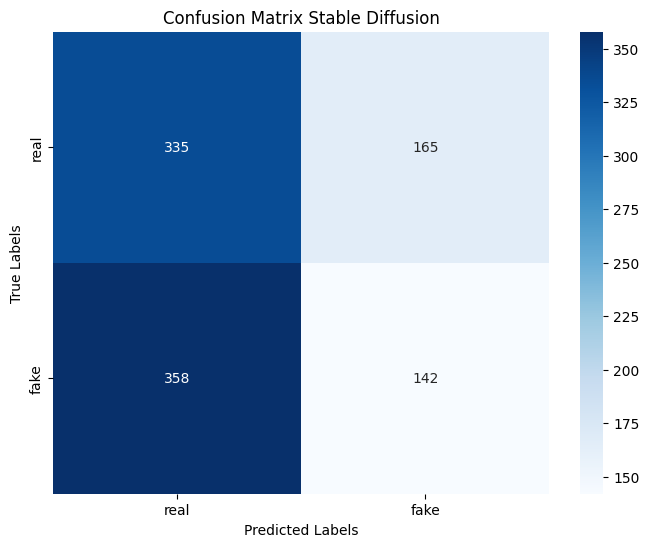

In [90]:
#Estraggo dalla matrice di confusione i True Negative, False Positive, False Negative, True Positive
TN, FP, FN, TP = confusion_matrix(y_true, y_pred, labels=["real", "fake"]).ravel()

# Plotto la matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["real", "fake"], yticklabels=["real", "fake"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Stable Diffusion')
# Salvo l'immagine
plt.savefig('confusion_matrix_1500(stablediffusion-coco)_second_series-test.png')
plt.show()

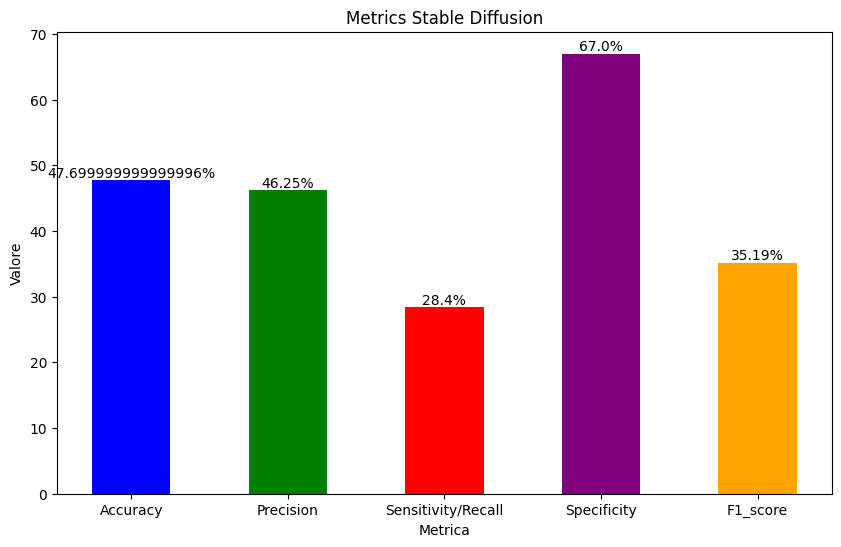

In [91]:
#Calcolo alcune metriche per vedere come si comporta
accuracy = round((TP + TN) /(TP + TN + FP + FN), 4) * 100
precision = round((TP) / (TP + FP), 4) * 100
sensitivy_recall = round((TP) / (TP + FN), 4) * 100
specificity = round((TN) / (TN + FP) * 100, 4)
F1_score = round((2* precision * sensitivy_recall) / (precision + sensitivy_recall), 2)

metrics = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Sensitivity/Recall": sensitivy_recall,
    "Specificity": specificity,
    "F1_score": F1_score
}

# Nomi delle metriche
labels = list(metrics.keys())

# Valori delle metriche
values = list(metrics.values())

# Creazione dell'istogramma
plt.figure(figsize=(10,6))
plt.bar(labels, values, color=['blue', 'green', 'red', 'purple', 'orange'], width=0.5)

# Aggiunta delle etichette
for i in range(len(labels)):
    plt.text(i, values[i], f'{values[i]}%', ha = 'center', va = 'bottom')

# Titoli e etichette degli assi
plt.title('Metrics Stable Diffusion')
plt.xlabel('Metrica')
plt.ylabel('Valore')

plt.savefig('Metrics_with_stablediffusion-coco_second_series_test(1500imgs).png')

# Mostra l'istogramma
plt.show()

In [92]:
print({"Accuracy":accuracy,"Precision":precision,"Sensitivity_recall":sensitivy_recall, "Specificity": specificity, "F1_score":F1_score})

{'Accuracy': 47.699999999999996, 'Precision': 46.25, 'Sensitivity_recall': 28.4, 'Specificity': 67.0, 'F1_score': 35.19}


# Tests's results plot

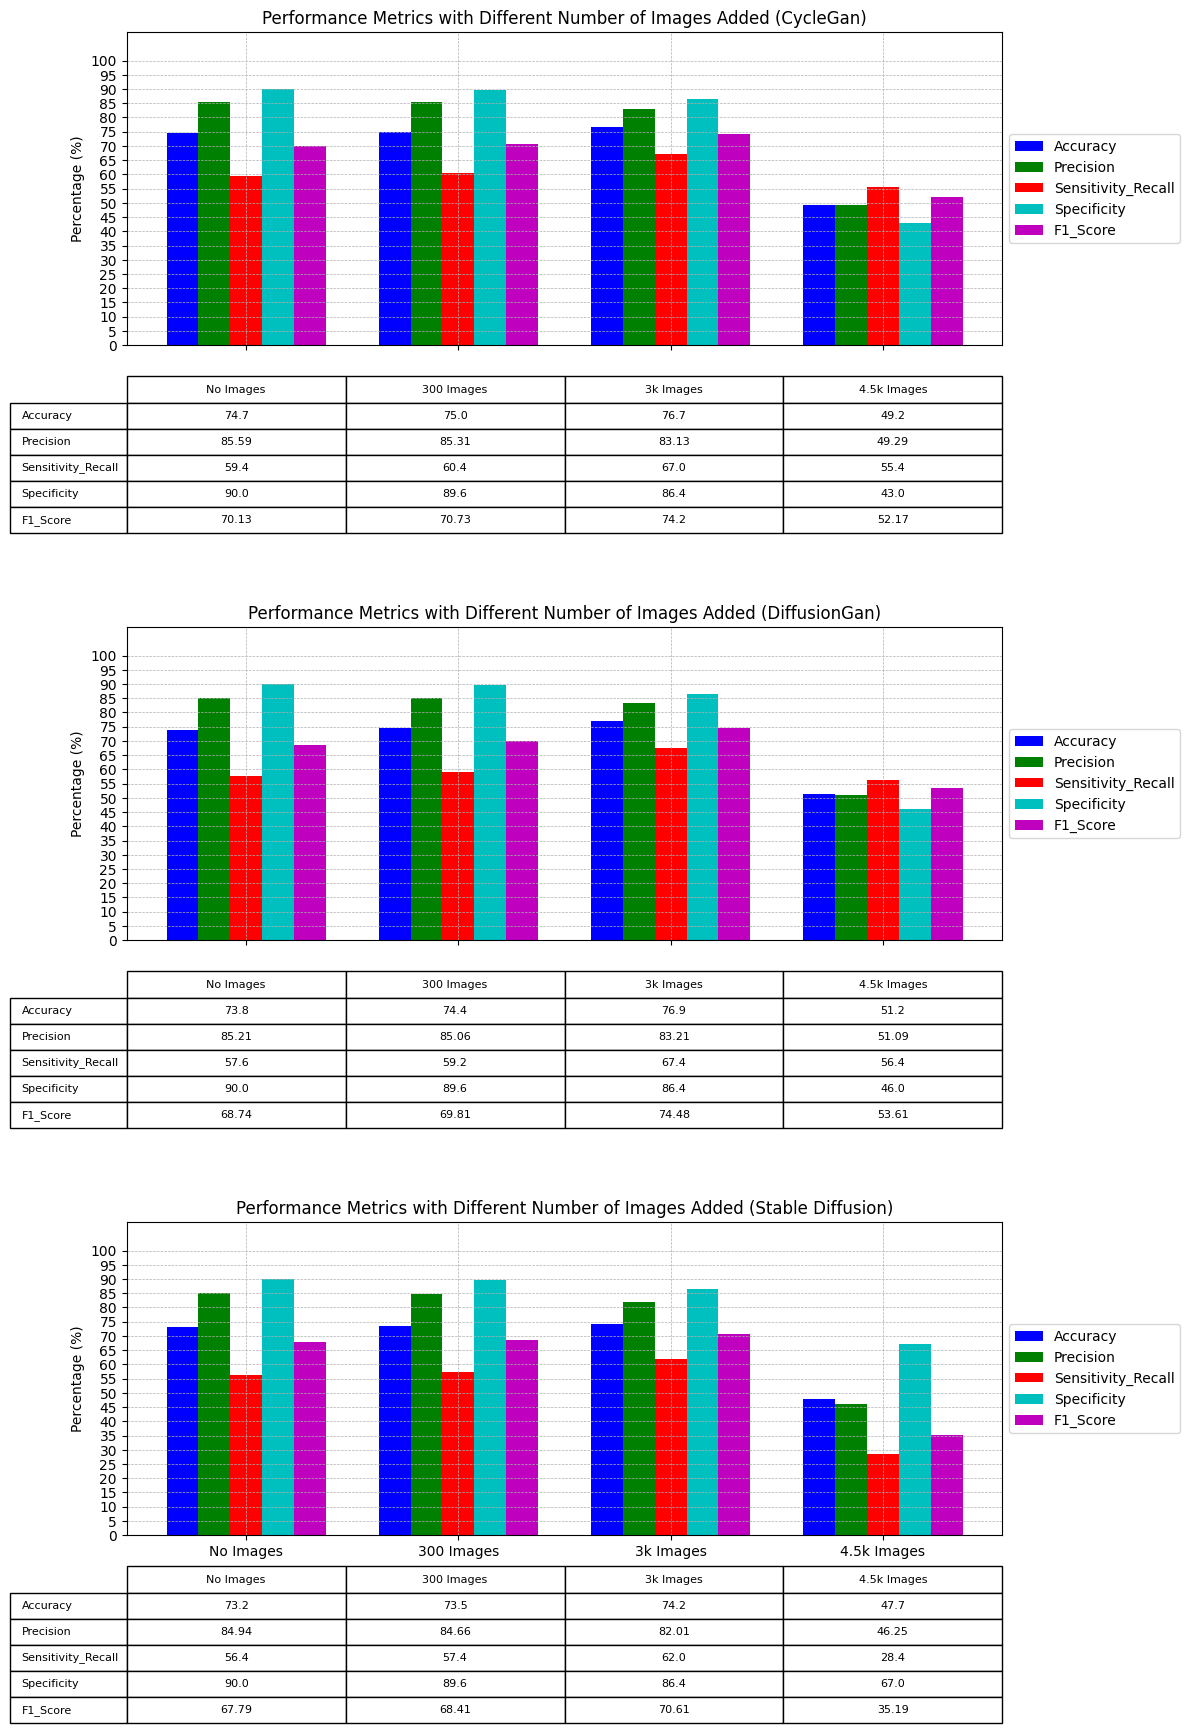

In [93]:
conditions = ['No Images', '300 Images', '3k Images', '4.5k Images']
metrics = ['Accuracy', 'Precision', 'Sensitivity_Recall', 'Specificity', 'F1_Score']
data1 = {
    'Accuracy': [74.7, 75.0, 76.7, 49.2],
    'Precision': [85.59, 85.31, 83.13, 49.29],
    'Sensitivity_Recall': [59.4, 60.4, 67.0, 55.40],
    'Specificity': [90.0, 89.6, 86.4, 43.0],
    'F1_Score': [70.13, 70.73, 74.2, 52.17]
}
data2 = {
    'Accuracy': [73.8, 74.4, 76.9, 51.2],
    'Precision': [85.21, 85.06, 83.21, 51.09],
    'Sensitivity_Recall': [57.60, 59.20, 67.4, 56.40],
    'Specificity': [90.0, 89.6, 86.4, 46.0],
    'F1_Score': [68.74, 69.81, 74.48, 53.61]
}
data3 = {
    'Accuracy': [73.2, 73.5, 74.2, 47.70],
    'Precision': [84.94, 84.66, 82.01, 46.25],
    'Sensitivity_Recall': [56.40, 57.4, 62.0, 28.4],
    'Specificity': [90.0, 89.6, 86.4, 67.0],
    'F1_Score': [67.79, 68.41, 70.61, 35.19]
}

# Parametri di configurazione
bar_width = 0.15  # Larghezza delle barre
index = np.arange(len(conditions))  # Posizioni delle condizioni sull'asse x
colors = ['b', 'g', 'r', 'c', 'm']  # Colori delle barre

# Creazione della figura e degli assi
fig, axs = plt.subplots(nrows=3, figsize=(12, 18), sharex=True)

for ax in axs:
    ax.set_xticks(index + 2 * bar_width)
    ax.set_xticklabels(conditions)

# Funzione per plottare i dati in un subplot
def plot_metrics(ax, data, title):
    for i, metric in enumerate(metrics):
        bars = ax.bar(index + i * bar_width, data[metric], bar_width, label=metric, color=colors[i])
    ax.set_ylabel('Percentage (%)')
    ax.set_title(title)
    ax.set_ylim(0, 110)  # Aumenta il limite superiore per spazio extra
    ax.set_yticks(np.arange(0, 101, 5))  # Tacche sull'asse y ogni 5%
    # Aggiunta delle linee della griglia per ogni tick
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Creazione della tabella con i valori
    table_data = [data[metric] for metric in metrics]
    row_labels = metrics
    col_labels = conditions
    table_data = np.round(np.array(table_data), 2)

    # Aggiunta della tabella accanto al grafico
    table = ax.table(cellText=table_data, rowLabels=row_labels, colLabels=col_labels, cellLoc='center', loc='bottom', bbox=[0, -0.6, 1, 0.5])
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1, 1.5)  # Regola la dimensione della tabella
    
# Plot dei dati
plot_metrics(axs[0], data1, 'Performance Metrics with Different Number of Images Added (CycleGan)')
plot_metrics(axs[1], data2, 'Performance Metrics with Different Number of Images Added (DiffusionGan)')
plot_metrics(axs[2], data3, 'Performance Metrics with Different Number of Images Added (Stable Diffusion)')

plt.tight_layout()
plt.savefig('Concat_Metrics_CycleGan_DiffusionGan_StableDiffusion.png')    
plt.show()